In [1]:
import os
import numpy as np
import pandas as pd
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import random
import tensorflow as tf
from transformers import AutoTokenizer
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix , accuracy_score , classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle
import platform
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from tensorflow.keras.layers import Dense, Embedding, Conv1D, LSTM, Reshape, AveragePooling1D, GlobalMaxPooling1D, Input, MaxPooling1D, Dropout, Flatten,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from keras import regularizers
import re
seed=2023

In [2]:
print(platform.python_version())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.9.12
Num GPUs Available:  1


In [3]:
df0 = pd.read_excel("E:/CNSI_project/demo_and_data_5.0/Processed_data/Extr_val/aim2_dataset_ExVal_v2.0_mentalstatus1.xlsx")
df0 = df0.iloc[:,:-1]
df0

,subject_id,hadm_id,chartdate,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,...,C_Protein,C_Eosinophils,C_Polys,C_RBC,age,resprate,acuity,Chief Complaint,icd_title,hospital_expire_flag
0,31,128652,2108-08-23,NaN,NaN,8.1,103.0,204.0,2.2,11.0,...,63.0,NaN,37.0,435000.0,72,12.076923,NaN,"movement pupils sz activity, s sz, s, sinifica...",Antineoplastic and immunosuppressive drugs cau...,1
1,78,100536,2177-02-14,3.1,129.0,8.0,106.0,NaN,3.3,9.0,...,37.0,NaN,0.0,6.0,49,17.066667,NaN,headache hyper hypertens let lethargic sleepy ...,Accidental poisoning by benzodiazepine-based t...,0
2,92,142807,2122-12-17,NaN,NaN,NaN,109.0,NaN,NaN,NaN,...,142.0,NaN,0.0,94.0,0,NaN,NaN,"whiteions, edema, br abrasion, hyperirubmia, h...",Acidosis; Anemia of prematurity; Chronic respi...,0
3,93,160481,2128-03-23,NaN,NaN,NaN,104.0,NaN,NaN,NaN,...,101.0,3.0,43.0,42.0,0,NaN,NaN,"mumur sl jaundice, opening, hyperirub status, ...",25-26 completed weeks of gestation; Anemia of ...,0
4,110,154943,2110-06-02,NaN,126.0,NaN,106.0,NaN,NaN,NaN,...,109.0,NaN,1.0,153.0,0,NaN,NaN,"sis rash, discomfort headache, rash, headache ...",Need for prophylactic vaccination and inoculat...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,32626,149195,2107-06-11,NaN,NaN,9.0,96.0,NaN,3.3,16.0,...,327.0,NaN,76.0,0.0,33,17.357143,NaN,"waking disorienteras, pain turn, propiorecepti...","Depressive disorder, not elsewhere classified;...",0
1372,32656,153884,2186-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,167.0,NaN,7.0,43350.0,0,NaN,NaN,"tachypnea, scr pectus a b, headache overt s + ...",29-30 completed weeks of gestation; Neonatal j...,0
1373,32745,145060,2151-07-22,NaN,NaN,9.0,111.0,NaN,2.8,13.0,...,35.0,NaN,74.0,8850.0,64,25.266667,NaN,"nal nonpurposeful movements, opening eyes rous...",Acute respiratory failure; Alkalosis; Essentia...,0
1374,32749,138488,2171-10-17,NaN,NaN,10.2,98.0,NaN,3.5,11.0,...,26.0,NaN,13.0,8.0,22,33.040000,NaN,"pupil, asleep awake awake, cough secretions co...","Acidosis; Acute kidney failure, unspecified; A...",1


In [4]:
df0.hospital_expire_flag.value_counts()

0    1197
1     179
Name: hospital_expire_flag, dtype: int64

In [5]:
########### dataset 1 ########
df1 = df0.copy()
df1 = df1[["Chief Complaint","hospital_expire_flag"]]
df2 = df1.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# df2 = df2[df2['hospital_expire_flag'].notnull()]
# df2 = df2.dropna(thresh=2,axis=0)   # without even one Nan value
df2['hospital_expire_flag'] = df2['hospital_expire_flag'].astype(np.int16)
df2.rename(columns={'Chief Complaint':'English'},inplace=True)
df2

,English,hospital_expire_flag
0,"movement pupils sz activity, s sz, s, sinifica...",1
1,headache hyper hypertens let lethargic sleepy ...,0
2,"whiteions, edema, br abrasion, hyperirubmia, h...",0
3,"mumur sl jaundice, opening, hyperirub status, ...",0
4,"sis rash, discomfort headache, rash, headache ...",0
...,...,...
1371,"waking disorienteras, pain turn, propiorecepti...",0
1372,"tachypnea, scr pectus a b, headache overt s + ...",0
1373,"nal nonpurposeful movements, opening eyes rous...",0
1374,"pupil, asleep awake awake, cough secretions co...",1


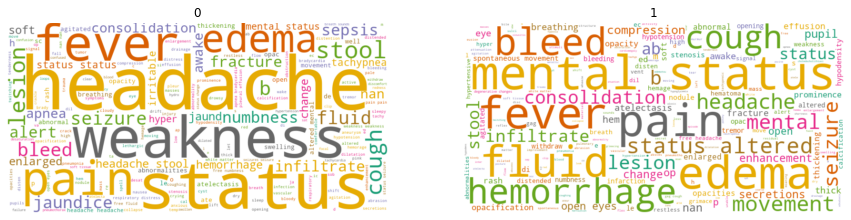

In [6]:
data = df2.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [7]:
########### dataset 2 ########
# loading structured data
df3 = df0.iloc[:,3:-3]
df3 = df3.loc[df2.index]

from sklearn.impute import KNNImputer
import pickle

with open('E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/imputer_KNNImputer_aim2.pickle', 'rb') as f:  
    imputer = pickle.load(f)

df_temp = imputer.transform(df3)
df3 = pd.DataFrame(df_temp, columns=df3.columns.tolist(), index=df3.index)

df3['hospital_expire_flag'] = df2['hospital_expire_flag']
df3

,B_Albumin,B_AlkalinePhosphatase,B_Calcium,B_Chloride,B_LactateDehydrogenase,B_Phosphate,B_UreaNitrogen,B_Eosinophils,B_INR(PT),B_MCV,...,B_WhiteBloodCells,C_LactateDehydrogenase,C_Protein,C_Eosinophils,C_Polys,C_RBC,age,resprate,acuity,hospital_expire_flag
0,3.754225,99.913348,8.100000,103.000000,204.000000,2.200000,11.000000,1.709322,1.100000,90.048217,...,9.622627,121.073890,63.0,3.031456,37.0,435000.0,72.0,12.076923,2.079988,1
1,3.100000,129.000000,8.000000,106.000000,191.990347,3.300000,9.000000,1.840435,1.200000,97.000000,...,1.600000,17.242754,37.0,1.000000,0.0,6.0,49.0,17.066667,2.264631,0
2,3.992285,88.714259,8.536469,109.000000,292.908296,3.324192,5.866684,1.221146,1.238114,90.340936,...,10.015474,58.867938,142.0,14.579488,0.0,94.0,0.0,18.833986,2.444295,0
3,3.725269,92.931141,8.556285,104.000000,232.637279,3.379484,7.230095,0.978467,1.158090,87.062966,...,8.975361,74.571943,101.0,3.000000,43.0,42.0,0.0,18.790402,2.227399,0
4,3.622793,126.000000,8.375652,106.000000,481.295514,3.544738,15.045427,8.000000,1.150068,105.000000,...,10.700000,21.502789,109.0,1.184610,1.0,153.0,0.0,16.646983,1.459160,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,4.067637,64.293340,9.000000,96.000000,299.105513,3.300000,16.000000,1.130596,1.069071,91.000000,...,10.200000,27.000000,327.0,2.391997,76.0,0.0,33.0,17.357143,2.140662,0
1372,3.886537,91.959960,8.538129,105.857164,231.843515,3.306441,10.496111,0.844893,1.171737,88.229285,...,9.411935,185.241602,167.0,2.730825,7.0,43350.0,0.0,18.900866,2.396010,0
1373,3.153040,144.829406,9.000000,111.000000,303.690934,2.800000,13.000000,2.478879,1.137808,82.000000,...,14.400000,267.498538,35.0,2.379775,74.0,8850.0,64.0,25.266667,2.007730,0
1374,3.995322,80.579152,10.200000,98.000000,247.377423,3.500000,11.000000,0.734757,1.300000,92.000000,...,21.200000,19.000000,26.0,3.182176,13.0,8.0,22.0,33.040000,1.995858,1


In [8]:
########### dataset 3 ########
df4 = df0.copy()
df4 = df4[["icd_title","hospital_expire_flag"]]
df4 = df4.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df4 = df4.loc[df2.index]
df4['hospital_expire_flag'] = df4['hospital_expire_flag'].astype(np.int16)
df4.rename(columns={'icd_title':'English'},inplace=True)

df4

,English,hospital_expire_flag
0,antineoplastic and immunosuppressive drugs cau...,1
1,accidental poisoning by benzodiazepine-based t...,0
2,acidosis; anemia of prematurity; chronic respi...,0
3,25-26 completed weeks of gestation; anemia of ...,0
4,need for prophylactic vaccination and inoculat...,0
...,...,...
1371,"depressive disorder, not elsewhere classified;...",0
1372,29-30 completed weeks of gestation; neonatal j...,0
1373,acute respiratory failure; alkalosis; essentia...,0
1374,"acidosis; acute kidney failure, unspecified; a...",1


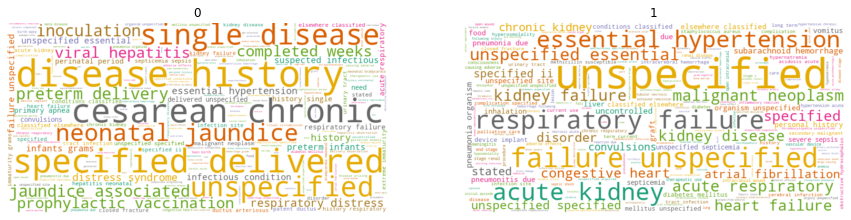

In [9]:
data = df4.copy()

# Group the data by label and concatenate the text data for each group
groups = data.groupby('hospital_expire_flag')['English'].apply(lambda x: ' '.join(str(i) for i in x))

# Generate a word cloud for each group
wordclouds = []
for group_name, group_data in groups.items():   # groups.items(): output keys and values in same time.
    # Create a word cloud object and generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Dark2',random_state=2023).generate(group_data)
    wordclouds.append((group_name, wc))

# Plot the word clouds
fig, axs = plt.subplots(1, len(wordclouds), figsize=(15, 10))
for i, (group_name, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(group_name)
    axs[i].axis('off')

plt.show()

In [10]:
# Load bioBERT tokenizer and model
pretrained_model = 'G:/BertModels/BioBERT'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

In [11]:
def text2vec(df_text, col, token_length):
    #col = "Chief Complaint"
    sentences_maxlength = 1398
    sentences = df_text[col].fillna("").values.tolist()
    encoding = tokenizer(sentences, 
                         add_special_tokens=False, 
                         return_tensors='tf', 
                         padding='max_length', 
                         truncation=True, 
                         max_length=sentences_maxlength)

    input_ids = encoding['input_ids']
    input_ids1 = input_ids.numpy()
    
#     ICD:34, ChiefComplaint:20
    input_ids1_cumF95 = input_ids1[:,:token_length]
    
    return input_ids1_cumF95

In [12]:
# Change the data form, then merge them
#################### testing set
X_test0 = text2vec(df2, 'English', 20)

X_test1 = df3.iloc[:,:-1].values

with open('E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/scaler_aim2.pickle', 'rb') as f:  
    scaler = pickle.load(f)
X_test1 = scaler.transform(X_test1)

X_test2 = text2vec(df4, 'English', 379)

X_test = np.concatenate([X_test0,X_test1,X_test2], axis=1)
y_test = df2['hospital_expire_flag'].values

print(X_test.shape)
X_test

(1376, 422)


array([[ 2230.,  7035.,   188., ...,     0.,     0.,     0.],
       [16320.,   177., 24312., ...,     0.,     0.,     0.],
       [ 1653.,  5266.,   117., ...,     0.,     0.,     0.],
       ...,
       [ 9468.,  1233.,  1664., ...,     0.,     0.,     0.],
       [11602.,   117.,  6153., ...,     0.,     0.,     0.],
       [ 7086., 10570.,  2997., ...,     0.,     0.,     0.]])

In [37]:
# load model
from tensorflow.keras.models import load_model

model = load_model('E:/CNSI_project/demo_and_data_5.0/models_v2.2/Aim2_ChiefStructuredICD_CNN.h5')

In [38]:
X_test_text = X_test[:,:20]
X_test_numeric = X_test[:,20:20+23]
X_test_icd = X_test[:,20+23:]
y_test

array([1, 0, 0, ..., 0, 1, 0], dtype=int16)

In [39]:
score,acc = model.evaluate([X_test_text,X_test_numeric,X_test_icd], y_test, verbose = 2)
print("score: %.3f" % (score))
print("acc: %.3f" % (acc))

43/43 - 0s - loss: 0.4292 - accuracy: 0.8140 - 489ms/epoch - 11ms/step
score: 0.429
acc: 0.814


In [40]:
predict_test = model.predict([X_test_text,X_test_numeric,X_test_icd])
predict_test

43/43 [==============================] - 0s 1ms/step


array([[2.0643552e-01, 7.9356444e-01],
       [9.9949896e-01, 5.0101016e-04],
       [8.7644953e-01, 1.2355051e-01],
       ...,
       [9.7225204e-02, 9.0277481e-01],
       [1.0824357e-01, 8.9175642e-01],
       [6.8887067e-01, 3.1112939e-01]], dtype=float32)

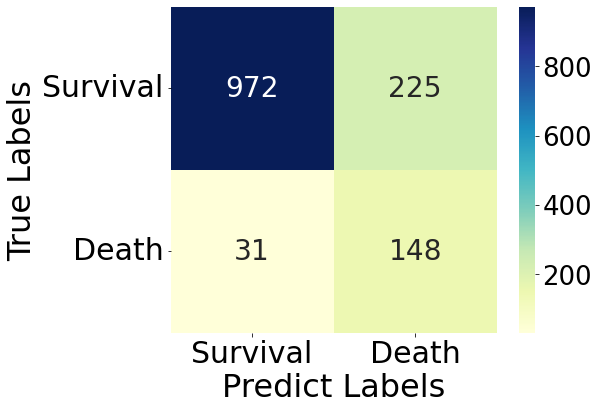

In [41]:
# generate confusion matrix
labels1 = ["Survival", "Death"]
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test, np.argmax(predict_test,axis=1))
ax = sns.heatmap(cm, square=True, annot=True , cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".0f")   #square=True, annot=True showing number
# plt.matshow(cm)
# plt.title('Confusion matrix DNN', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.colorbar()
plt.xticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)

plt.show()

In [42]:
cm

array([[972, 225],
       [ 31, 148]], dtype=int64)

In [43]:
predict_matrix = np.zeros(cm.shape)
for i in range(cm.shape[0]):
    temp = np.sum(cm[i])
    for j in range(cm.shape[1]):
        predict_matrix[i,j] = cm[i,j]/temp

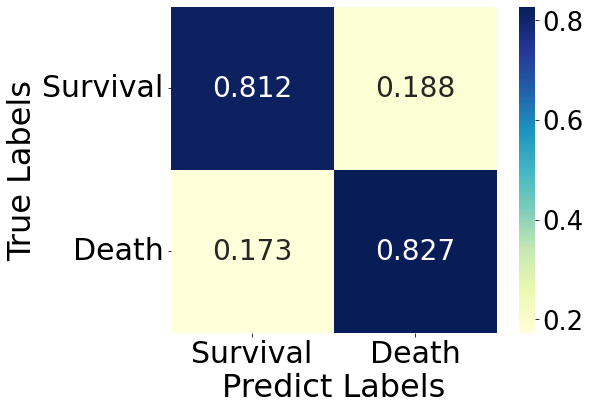

In [44]:
plt.figure(figsize = (8, 6))
ax = sns.heatmap(predict_matrix, square=True, annot=True ,cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".3f")
plt.xticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.title('Confusion matrix of prediction', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

plt.show()

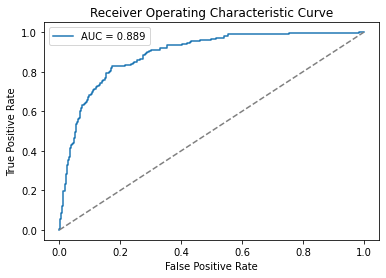

In [45]:
# Calculate AUC score and plot ROC curve
auc = roc_auc_score(y_test, predict_test[:,1])
fpr, tpr, thresholds = roc_curve(y_test, predict_test[:,1])

plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

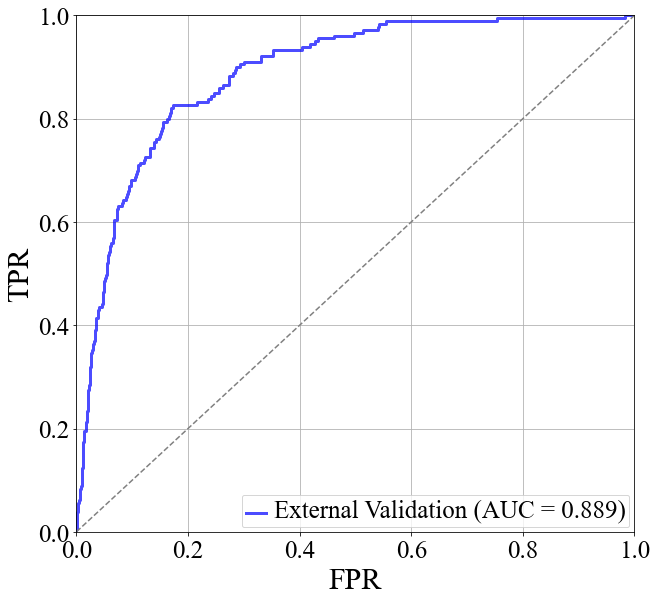

In [46]:
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, predict_test[:,1])
auc_cnn = roc_auc_score(y_test, predict_test[:,1])

plt.figure(figsize=(10, 9.5))
plt.plot(fpr_cnn, tpr_cnn, color='blue', label=f'External Validation (AUC = {auc_cnn:.3f})', linewidth=3, alpha=0.7)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('FPR', fontsize=30, fontname='Times New Roman')  # False Positive Rate
plt.ylabel('TPR', fontsize=30, fontname='Times New Roman')    # True Positive Rate

legend = plt.legend(loc='lower right')
for text in legend.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(25)
    
plt.grid()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize=25, fontname='Times New Roman')
plt.yticks(fontsize=25, fontname='Times New Roman')

path = os.path.join("E:/CNSI_project/demo_and_data_5.0/figure_in_paper/ExVal", "aim2auc.tif")
plt.savefig(path, dpi=300, bbox_inches='tight')

plt.show()

In [47]:
# calculate evaluation metric using test cohort
accuracy0 = np.round(accuracy_score(y_test, 
               np.argmax(predict_test,axis=1)), decimals = 3)
print('\n1dCNN Predictive Accuracy: ',accuracy0)


1dCNN Predictive Accuracy:  0.814


In [48]:
print('\nSummary of 1dCNN Precision and Recall\n') 
print(classification_report(y_test, np.argmax(predict_test,axis=1), 
                            target_names = labels1, digits=3))


Summary of 1dCNN Precision and Recall

              precision    recall  f1-score   support

    Survival      0.969     0.812     0.884      1197
       Death      0.397     0.827     0.536       179

    accuracy                          0.814      1376
   macro avg      0.683     0.819     0.710      1376
weighted avg      0.895     0.814     0.838      1376



In [25]:
df0['predict'] = predict_test.argmax(axis=1)
df0.to_excel("E:/CNSI_project/demo_and_data_5.0/Processed_data/Extr_val/aim2_dataset_ExVal_v2.0_mentalstatus1.xlsx",index=False)

# AUPRC、C-index and Brier Score

FCN AUPRC: 0.537
Baseline (positive class ratio): 0.130


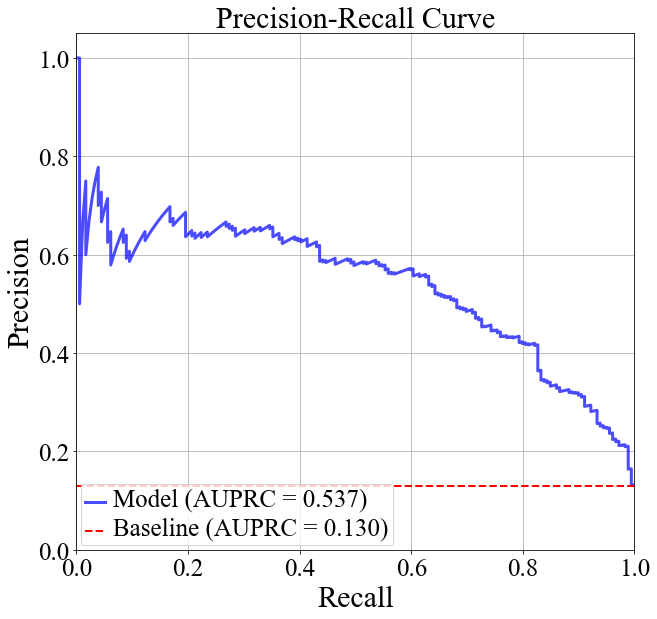

In [49]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, brier_score_loss
from lifelines.utils import concordance_index

# AUPRC
precision, recall, _ = precision_recall_curve(y_test, predict_test[:, 1])
auprc = auc(recall, precision)
print(f'FCN AUPRC: {auprc:.3f}')

baseline = sum(y_test) / len(y_test)
print(f'Baseline (positive class ratio): {baseline:.3f}')

plt.figure(figsize=(10, 9.5))
plt.plot(recall, precision, color='blue', label=f'Model (AUPRC = {auprc:.3f})', linewidth=3, alpha=0.7)

plt.axhline(y=baseline, color='red', linestyle='--', label=f'Baseline (AUPRC = {baseline:.3f})', linewidth=2)

plt.xlabel('Recall', fontsize=30, fontname='Times New Roman') 
plt.ylabel('Precision', fontsize=30, fontname='Times New Roman')
plt.title('Precision-Recall Curve', fontsize=30, fontname='Times New Roman')

legend = plt.legend(loc='lower left')
for text in legend.get_texts():
    text.set_fontname('Times New Roman')
    text.set_fontsize(25)

plt.grid()

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=25, fontname='Times New Roman')
plt.yticks(fontsize=25, fontname='Times New Roman')

plt.show()

In [50]:
# C-index
c_index = concordance_index(y_test, predict_test[:,1])
print(f'FCN C-index: {c_index:.3f}')

FCN C-index: 0.889


In [51]:
# Brier Score 
brier_score = brier_score_loss(y_test, predict_test[:,1])
print(f'FCN Brier Score: {brier_score:.3f}')

FCN Brier Score: 0.134
